In [62]:
import os
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time

In [63]:
class SingleSampleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        
        # Collect image paths and corresponding labels
        for series in os.listdir(root_dir):
            series_path = os.path.join(root_dir, series)
            if os.path.isdir(series_path):
                for img_name in os.listdir(series_path):
                    if ".json" in img_name:
                        continue
                    img_path = os.path.join(series_path, img_name)
                    self.image_paths.append(img_path)
                    
                    label = img_name  
                    if label not in self.label_to_idx:
                        idx = len(self.label_to_idx)
                        self.label_to_idx[label] = idx
                        self.idx_to_label[idx] = label
                    
                    self.labels.append(self.label_to_idx[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        # Convert image to RGB if it's not already in that mode
        if image.mode != "RGB":
            image = image.convert("RGB")

        label_idx = self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(label_idx), num_classes=len(self.label_to_idx))

        if self.transform:
            image = self.transform(image)

        return image, one_hot_label.float()
    
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(1, 1),),
    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.96, 1.06)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleSampleDataset(root_dir='cards', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

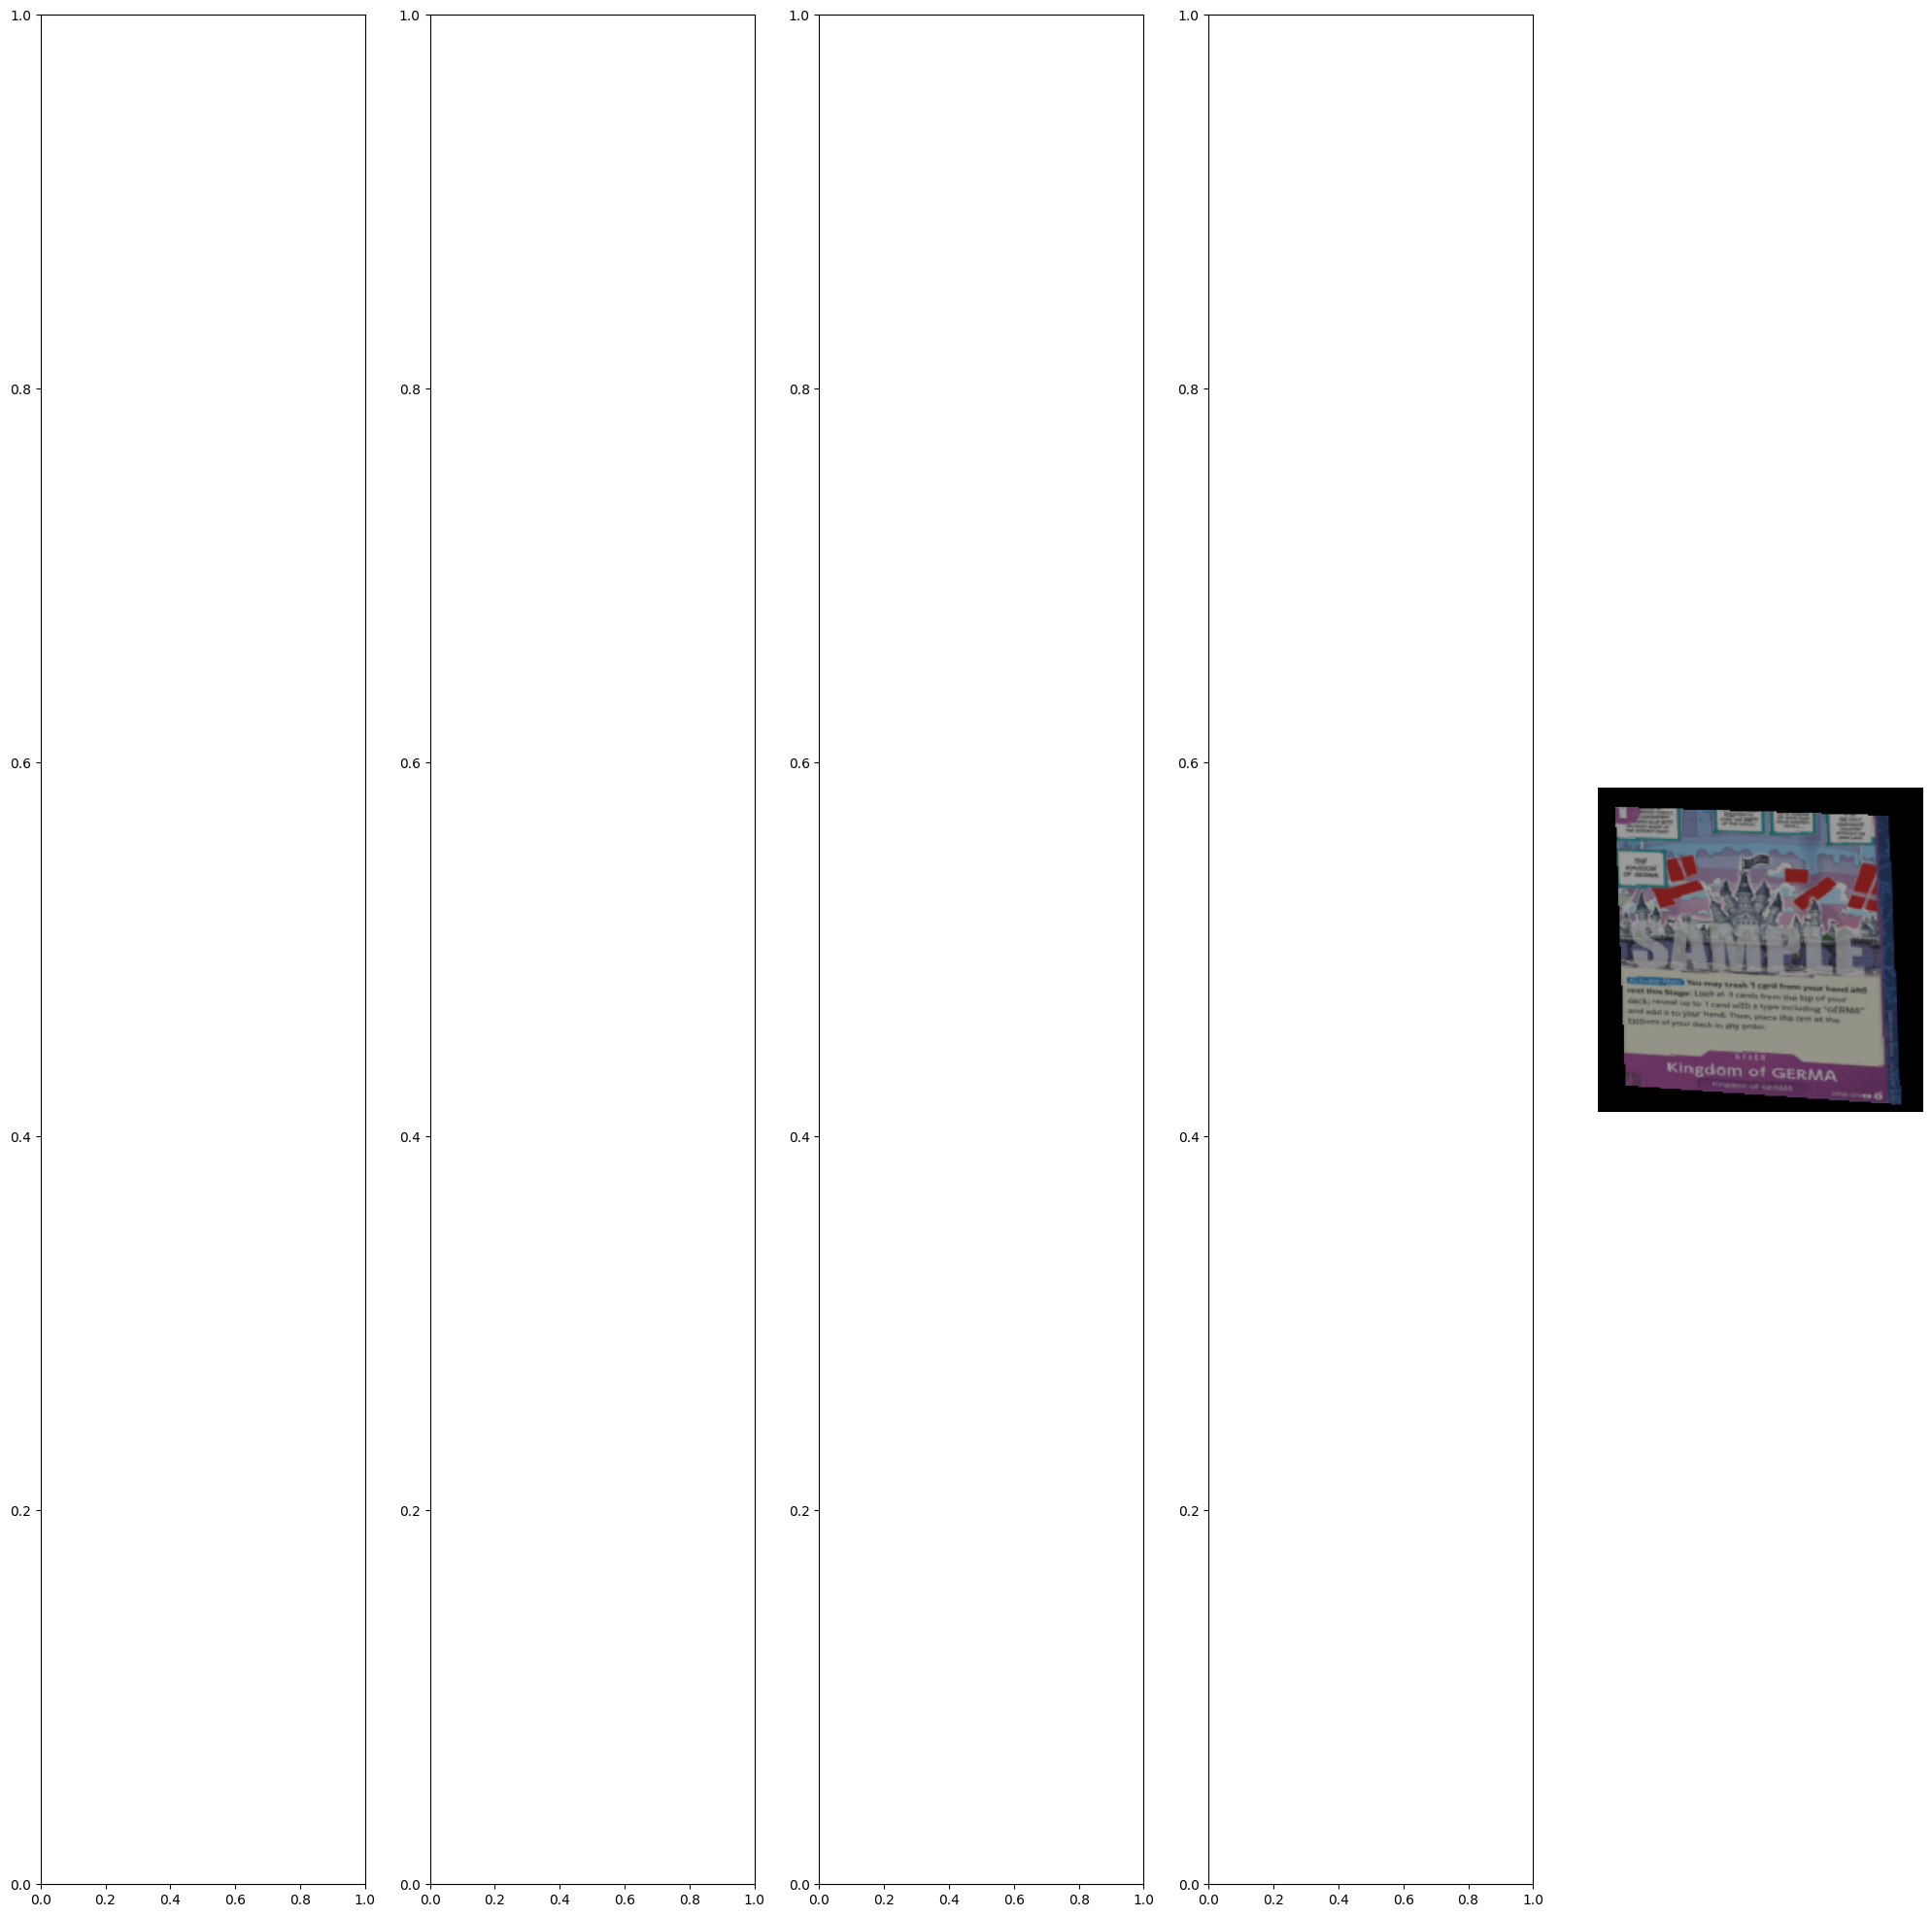

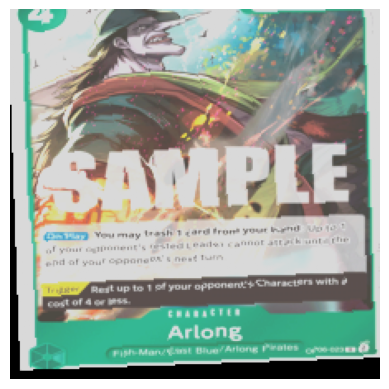

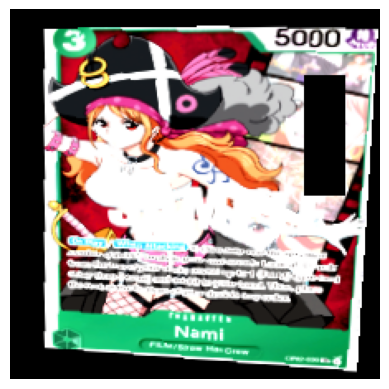

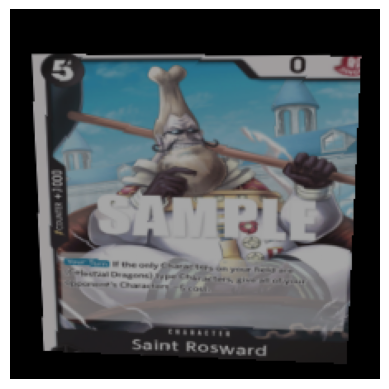

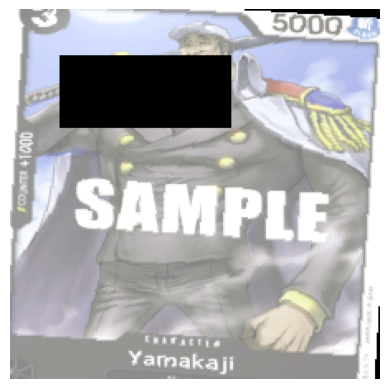

In [64]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# reverse normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

images = images * std[:, None, None] + mean[:, None, None]
images = images.numpy()
images = images.transpose((0, 2, 3, 1))
images = images[:5]
fig, axes = plt.subplots(1, len(images), figsize=(25, 25))
if len(images) == 1:
    axes = [axes]

for img in images:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [65]:
base_model = models.resnet18(pretrained=True)

# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False


# Get the number of features from the original fully connected layer
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Identity()

embedding_size = 128

class CardModel(nn.Module):
    def __init__(self, base_model, embedding_size):
        super(CardModel, self).__init__()
        self.base_model = base_model
        self.embedding_layer = nn.Linear(num_ftrs, embedding_size)
        self.classification_layer = nn.Linear(embedding_size, len(dataset.labels))

    def forward(self, x):
        x = self.base_model(x)
        x = self.embedding_layer(x) 
        logits = self.classification_layer(x)
        return x, logits
    
device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")
model = CardModel(base_model, embedding_size).to(device)

/Users/jan/.local/share/virtualenvs/tcg-scanner--verKe1I/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jan/.local/share/virtualenvs/tcg-scanner--verKe1I/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [66]:
criterion = nn.CrossEntropyLoss()

def train_loop(num_epochs, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, one_hot_labels in train_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)

            optimizer.zero_grad()
            embeddings, logits = model(inputs)
            
            labels = torch.argmax(one_hot_labels, dim=1)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()
        
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loop(40, optimizer)

Epoch 1/40, Loss: 7.1503, Accuracy: 0.00%
Epoch 2/40, Loss: 7.2081, Accuracy: 0.19%
Epoch 3/40, Loss: 7.0000, Accuracy: 0.19%
Epoch 4/40, Loss: 6.8900, Accuracy: 0.37%
Epoch 5/40, Loss: 6.7591, Accuracy: 0.47%
Epoch 6/40, Loss: 6.6006, Accuracy: 1.50%
Epoch 7/40, Loss: 6.4337, Accuracy: 2.16%
Epoch 8/40, Loss: 6.2283, Accuracy: 3.37%
Epoch 9/40, Loss: 5.9856, Accuracy: 7.03%
Epoch 10/40, Loss: 5.6985, Accuracy: 8.81%
Epoch 11/40, Loss: 5.4012, Accuracy: 11.90%
Epoch 12/40, Loss: 5.1103, Accuracy: 15.75%
Epoch 13/40, Loss: 4.7777, Accuracy: 21.09%
Epoch 14/40, Loss: 4.4127, Accuracy: 28.77%
Epoch 15/40, Loss: 3.9749, Accuracy: 37.11%
Epoch 16/40, Loss: 3.6952, Accuracy: 40.86%
Epoch 17/40, Loss: 3.4426, Accuracy: 48.45%
Epoch 18/40, Loss: 3.0764, Accuracy: 54.64%
Epoch 19/40, Loss: 2.7613, Accuracy: 60.17%
Epoch 20/40, Loss: 2.4950, Accuracy: 64.57%
Epoch 21/40, Loss: 2.1880, Accuracy: 69.73%
Epoch 22/40, Loss: 1.9091, Accuracy: 74.51%
Epoch 23/40, Loss: 1.8655, Accuracy: 74.32%
Epoch 2

In [68]:
# model = torch.load(f'{time.time()}_model_save.pth')

In [69]:
# Optionally, unfreeze more layers and fine-tune with a lower learning rate
for param in model.base_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_loop(10, optimizer)

Epoch 1/10, Loss: 0.4705, Accuracy: 92.41%
Epoch 2/10, Loss: 0.3351, Accuracy: 94.85%
Epoch 3/10, Loss: 0.2589, Accuracy: 95.97%
Epoch 4/10, Loss: 0.2710, Accuracy: 95.69%
Epoch 5/10, Loss: 0.2078, Accuracy: 97.28%
Epoch 6/10, Loss: 0.1926, Accuracy: 96.91%
Epoch 7/10, Loss: 0.1980, Accuracy: 97.56%
Epoch 8/10, Loss: 0.1615, Accuracy: 97.84%
Epoch 9/10, Loss: 0.1546, Accuracy: 98.03%
Epoch 10/10, Loss: 0.1443, Accuracy: 97.94%


In [70]:
torch.save(model.state_dict(), f'{time.time()}_model_state_dict.pth')
torch.save(model, f'{time.time()}_model_save.pth')

In [71]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels.to(device), dim=1)
        embeddings, logits = model(inputs.to(device))
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f'Accuracy: {100 * correct / total}%')

Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 99.21875%
Accuracy: 99.375%
Accuracy: 98.4375%
Accuracy: 97.76785714285714%
Accuracy: 97.65625%
Accuracy: 97.56944444444444%
Accuracy: 97.8125%
Accuracy: 98.01136363636364%
Accuracy: 98.17708333333333%
Accuracy: 97.83653846153847%
Accuracy: 97.76785714285714%
Accuracy: 97.70833333333333%
Accuracy: 97.65625%
Accuracy: 97.79411764705883%
Accuracy: 97.91666666666667%
Accuracy: 98.02631578947368%
Accuracy: 98.125%
Accuracy: 98.06547619047619%
Accuracy: 98.01136363636364%
Accuracy: 97.96195652173913%
Accuracy: 98.046875%
Accuracy: 98.125%
Accuracy: 98.07692307692308%
Accuracy: 98.14814814814815%
Accuracy: 98.21428571428571%
Accuracy: 98.27586206896552%
Accuracy: 98.33333333333333%
Accuracy: 98.28629032258064%
Accuracy: 98.33984375%
Accuracy: 98.29545454545455%
Accuracy: 98.31302717900655%


In [72]:
# preprocesing for forward pass
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and std
])

def extract_embedding(model, img_path):
    model.eval()
    image = Image.open(img_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = transform(image)
    with torch.no_grad():
        embedding, logits = model(image.unsqueeze(0).to(device))
    return F.normalize(embedding, p=2, dim=1).cpu().numpy().flatten(), logits



OP05-119.jpg


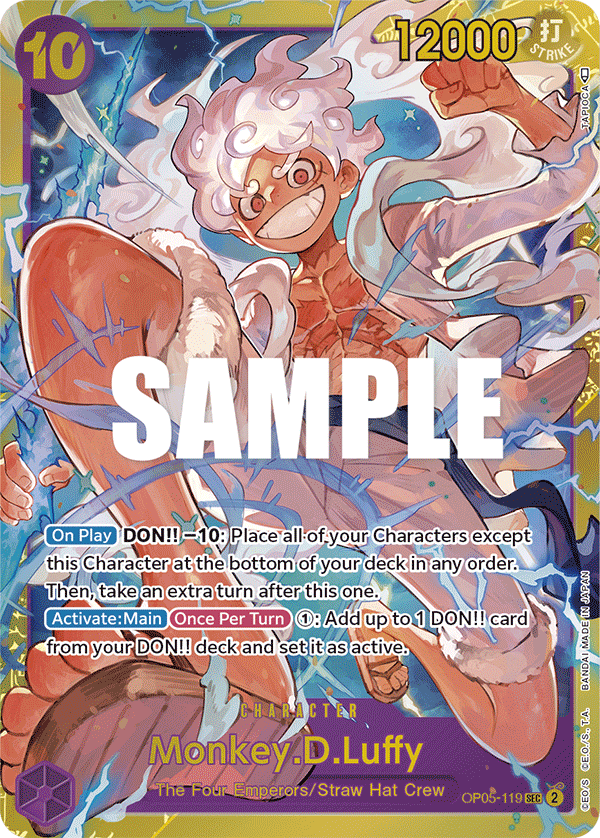

In [73]:
embedding, logits = extract_embedding(model, "monkey.png")

probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

predicted_class = predicted_class.item()
predicted_class_name = dataset.idx_to_label[predicted_class]
print(predicted_class_name)
series_id = predicted_class_name[2:4]
series_folder = f"series-{series_id}"

image = Image.open("cards/" +  series_folder + "/" + predicted_class_name)
image

In [74]:
from tqdm import tqdm

card_embeddings = []
root_dir = "cards"
index = 0
index_to_card_id = {}

for series in os.listdir(root_dir):
    series_path = os.path.join(root_dir, series)
    if os.path.isdir(series_path):
        for img_name in tqdm(os.listdir(series_path)):
            if ".json" in img_name:
                continue
            img_path = os.path.join(series_path, img_name)
            label = img_name  
            embedding, _ = extract_embedding(model, img_path)
            card_embeddings.append(embedding)
            index_to_card_id[index] = label
            index += 1

100%|██████████| 302/302 [00:05<00:00, 56.18it/s]


In [75]:
from sklearn.metrics.pairwise import euclidean_distances
from pathlib import Path

def find_image_path(card_id, root_dir="cards"):
    root_path = Path(root_dir)
    for image_path in root_path.rglob(f"{card_id}"):
        return image_path
    return None

card_embeddings = np.array(card_embeddings, dtype='float32')

# Define a query vector
query_embedding, _ = extract_embedding(model, "monkey.png") 
query_embedding = np.array([query_embedding]) 

distances = euclidean_distances(card_embeddings, query_embedding)

# Find the indices of the 5 closest vectors
top_k = 5
closest_indices = np.argsort(distances.flatten())[:top_k]

# Retrieve the closest card IDs
closest_card_ids = [index_to_card_id[idx] for idx in closest_indices]
closest_distances = [distances[idx][0] for idx in closest_indices]

Match 1:
Card ID: OP05-119.jpg
Distance: 0.5559353828430176


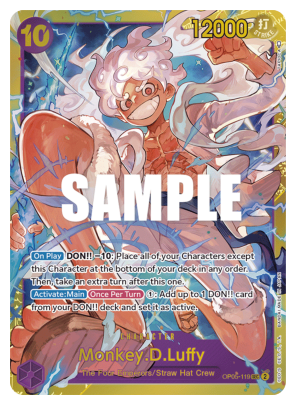

Match 2:
Card ID: OP06-118.jpg
Distance: 0.7314758896827698


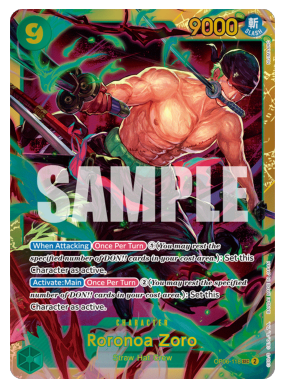

Match 3:
Card ID: OP04-112_p1.jpg
Distance: 0.7471574544906616


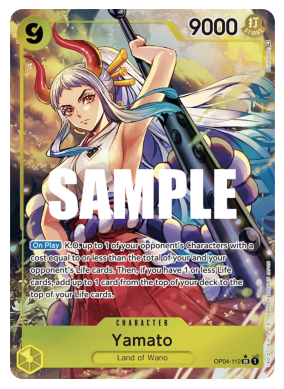

Match 4:
Card ID: OP01-078_p1.jpg
Distance: 0.7613268494606018


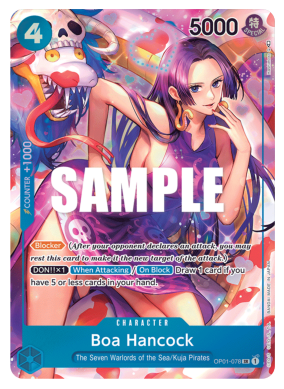

Match 5:
Card ID: OP07-118.jpg
Distance: 0.7785562872886658


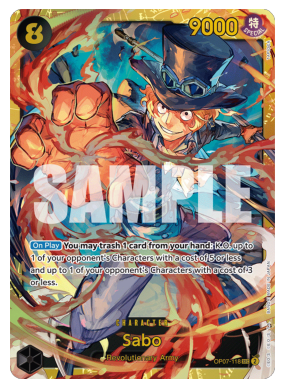

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if top_k == 1:
    axes = [axes] 

for i, card_id in enumerate(closest_card_ids):
    image_path = find_image_path(card_id)
    if image_path:
        image = Image.open(image_path)
        print(f"Match {i + 1}:")
        print(f"Card ID: {card_id}")
        print(f"Distance: {closest_distances[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()